In [1]:
import itertools
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D

from lab import metrics

# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
def load_data(config_path: str = "../config/config.yaml"):
    with open(config_path, mode="r") as configfile:
        config = yaml.safe_load(configfile)
        
    keys = list(itertools.product(config["quic_feature_steps"], range(10)))
    return pd.concat([
        pd.read_csv(f"../results/tree-importance/kfp-ext-quic-{step}-{rep:02d}.csv")
        for step, rep in keys
    ], keys=keys, names=["step", "repetition"])

dataset = load_data()
display(dataset)

y_true   -1    0    1    2    3    4    5    6    7  \
step repetition                                                             
20   0          0       61.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                1       79.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                2       49.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                3       -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                4       -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
650  9          5852    18.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                5853    68.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                5854    -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                5855    -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                5856    -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                      ...   90   91   92   93   94   95   96   97   98   99  
step repetition       ...                                                    
20   0          0     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                1     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                2     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                3     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                4     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
650  9          5852  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                5853  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                5854  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                5855  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
                5856  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[585700 rows x 102 columns]

In [3]:
def score(frame, ratio):
    y_true = frame["y_true"]
    
    classes = np.arange(-1, 100)
    predictions = frame.loc[:, [str(x) for x in range(-1, 100)]].values
    y_pred = classes[np.argmax(predictions, axis=1)]
    
    return pd.Series({
        "precision": metrics.rprecision_score(y_true, y_pred, ratio=ratio),
        "recall": metrics.recall_score(y_true, y_pred)
    })

scores = dataset.groupby(["step", "repetition"]).apply(score, ratio=20).transform(lambda x: x*100)
display(scores)

precision  recall
step repetition                   
20   0           80.478364    87.4
     1           80.912389    87.7
     2           82.692638    88.0
     3           79.964537    88.7
     4           81.965874    87.0
...                    ...     ...
650  5           90.449951    97.5
     6           96.290521    96.2
     7           92.529146    96.9
     8           93.320427    97.8
     9           95.199866    98.0

[100 rows x 2 columns]

In [4]:
plot_data = (scores
             .rename_axis("metric", axis=1).stack()
             .rename("score")
             .rename({"precision": "$\pi_{20}$", "recall": "Recall"})
             .reset_index())
display(plot_data)

,step,repetition,metric,score
0,20,0,$\pi_{20}$,80.478364
1,20,0,Recall,87.400000
2,20,1,$\pi_{20}$,80.912389
3,20,1,Recall,87.700000
4,20,2,$\pi_{20}$,82.692638
...,...,...,...,...
195,650,7,Recall,96.900000
196,650,8,$\pi_{20}$,93.320427
197,650,8,Recall,97.800000
198,650,9,$\pi_{20}$,95.199866


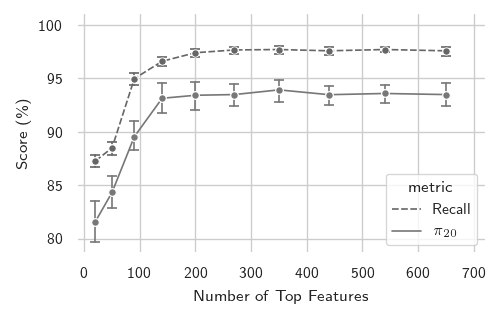

In [9]:
def plot(plot_data):
    figure, axes = plt.subplots(figsize=(3.5, 2.1), dpi=150)

    sns.lineplot(
        data=plot_data, x="step", y="score", hue="metric", style="metric",
        err_style="bars", ax=axes, seed=25550, hue_order=["Recall", r"$\pi_{20}$"],
        err_kws=dict(capthick=.8)
    )

    axes.set_xlabel("Number of Top Features")
    axes.set_ylabel(r"Score (\%)")
    axes.set_ylim(top=101)
    axes.set_xticks(np.arange(0, 800, 100))
    axes.set_xlim(right=720)

    axes.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    axes.yaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    
    axes.get_children()[3].set_markeredgecolor("white")
    axes.get_children()[7].set_markeredgecolor("white")
    
    sns.despine(left=True, bottom=True)
    
    return figure


with plt.style.context([
    "mpl-style/pets.mplstyle", "mpl-style/white-grid.mplstyle", 
    "mpl-style/line-plots.mplstyle", {"text.usetex": True}
]):
    figure = plot(plot_data)
    figure.savefig("../results/plots/quic-feature-scores.pgf", bbox_inches="tight", dpi=150)
    figure.savefig("../results/plots/quic-feature-scores.png", bbox_inches="tight", dpi=150)